# [DLthon] 오늘의 계획
- Task에 알맞는 적절한 모델 선정
- 모델 구축
- 적절한 metric 설정

# VGG16 모델

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os

In [63]:
# 데이터 경로 설정
base_dir = "./Train_Test_Valid_preprocessed"
train_dir = os.path.join(base_dir, "Train_Cleaned")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

In [64]:
# 하이퍼파라미터 설정
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

In [65]:
# 데이터 증강 및 전처리 (Train 데이터에는 증강 적용, Valid/Test에는 적용 X)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [66]:
# 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 846 images belonging to 6 classes.
Found 39 images belonging to 6 classes.
Found 40 images belonging to 6 classes.


In [67]:
# VGG16 모델 불러오기 (사전 학습된 가중치 사용, 최상위 분류층 제거)
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 기존 VGG16 모델의 가중치를 고정
for layer in vgg16_base.layers:
    layer.trainable = False

# 새로운 출력층 추가
x = Flatten()(vgg16_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)  # 해파리 종류 6개 클래스

In [68]:
# 모델 정의
model = Model(inputs=vgg16_base.input, outputs=x)

# 모델 컴파일
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# 모델 학습
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator
)

Epoch 1/20
27/27 [==============================] - 11s 373ms/step - loss: 1.7292 - accuracy: 0.3038 - val_loss: 1.4410 - val_accuracy: 0.4615
Epoch 2/20
27/27 [==============================] - 10s 375ms/step - loss: 1.1535 - accuracy: 0.5745 - val_loss: 1.2257 - val_accuracy: 0.5897
Epoch 3/20
27/27 [==============================] - 10s 377ms/step - loss: 0.9863 - accuracy: 0.6454 - val_loss: 1.1681 - val_accuracy: 0.5897
Epoch 4/20
27/27 [==============================] - 10s 366ms/step - loss: 0.8392 - accuracy: 0.7163 - val_loss: 1.1466 - val_accuracy: 0.5897
Epoch 5/20
27/27 [==============================] - 10s 359ms/step - loss: 0.7991 - accuracy: 0.7021 - val_loss: 1.2808 - val_accuracy: 0.6154
Epoch 6/20
27/27 [==============================] - 10s 368ms/step - loss: 0.6960 - accuracy: 0.7459 - val_loss: 1.2472 - val_accuracy: 0.6154
Epoch 7/20
27/27 [==============================] - 10s 366ms/step - loss: 0.6520 - accuracy: 0.7624 - val_loss: 1.2787 - val_accuracy: 0.6154

In [69]:
# 모델 평가
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# 모델 저장
model.save("vgg16_jellyfish_classifier.h5")

2/2 [==============================] - 0s 58ms/step - loss: 0.5144 - accuracy: 0.8750
Test Accuracy: 87.50%


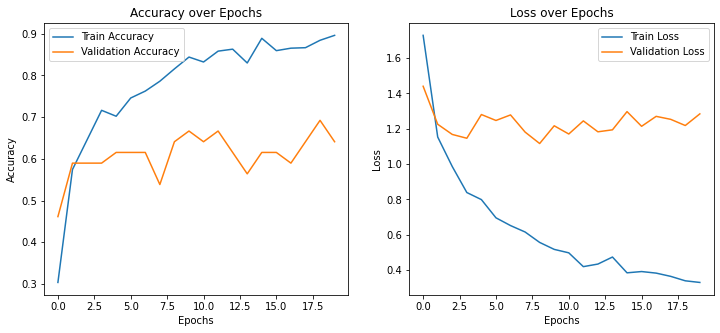

In [70]:
# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

## 모델 성능 조정 1
- VGG16의 일부 레이어 미세 조정 (Fine-tuning) → 마지막 4개 레이어 학습 가능하게 변경
- 데이터 증강 개선 → 밝기 조정, 색상 채널 이동 추가
- Optimizer 변경 (SGD + Momentum + Learning Rate Scheduling) → 학습 안정화 및 일반화 성능 향상
- EarlyStopping 추가 → Validation Loss가 개선되지 않으면 자동 종료하여 과적합 방지
- Batch Normalization 추가 → 모델 학습 안정화 및 수렴 속도 향상

## 모델 성능 조정 2
- 학습률(Learning Rate) 감소 → 0.01 → 1e-5로 변경하여 학습 안정화
- Fine-Tuning 범위 축소 → 마지막 5개 레이어만 학습 가능하도록 변경
- 데이터 증강 축소 → 과도한 brightness_range, channel_shift_range 제거
- Batch Size 감소 → 32 → 16으로 변경하여 Gradient Update 안정화
- EarlyStopping 개선 → patience=7 → 10으로 변경하여 학습 종료를 늦춤

## 모델 성능 조정 3
- Learning Rate 조정 → min_lr=1e-5로 설정하여 학습률이 지나치게 작아지는 것 방지
- Fine-Tuning 범위 확장 → VGG16의 마지막 5개 레이어 학습 가능하도록 변경
- 데이터 증강 강화 → 밝기 조정(brightness_range), 색상 채널 이동(channel_shift_range) 추가
- Dropout 강화 → Dense Layer 추가 (512 → 256 레이어 추가) & Dropout 2회 적용
- Epochs 증가 및 EarlyStopping 개선 → patience=15으로 증가하여 충분한 학습 보장

# EfficientNet

16818176/16804768 [==============================] - 0s 0us/step
Found 846 images belonging to 6 classes.
Found 39 images belonging to 6 classes.
Epoch 1/30
27/27 [==============================] - 22s 466ms/step - loss: 1.8552 - accuracy: 0.1596 - val_loss: 1.8053 - val_accuracy: 0.2308
Epoch 2/30
27/27 [==============================] - 10s 374ms/step - loss: 1.7664 - accuracy: 0.2009 - val_loss: 1.7553 - val_accuracy: 0.3077
Epoch 3/30
27/27 [==============================] - 10s 370ms/step - loss: 1.6905 - accuracy: 0.2730 - val_loss: 1.7118 - val_accuracy: 0.3333
Epoch 4/30
27/27 [==============================] - 10s 368ms/step - loss: 1.6334 - accuracy: 0.3357 - val_loss: 1.6697 - val_accuracy: 0.3590
Epoch 5/30
27/27 [==============================] - 10s 365ms/step - loss: 1.5838 - accuracy: 0.3842 - val_loss: 1.6136 - val_accuracy: 0.4615
Epoch 6/30
27/27 [==============================] - 10s 376ms/step - loss: 1.5117 - accuracy: 0.4704 - val_loss: 1.5534 - val_accuracy: 0.4

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


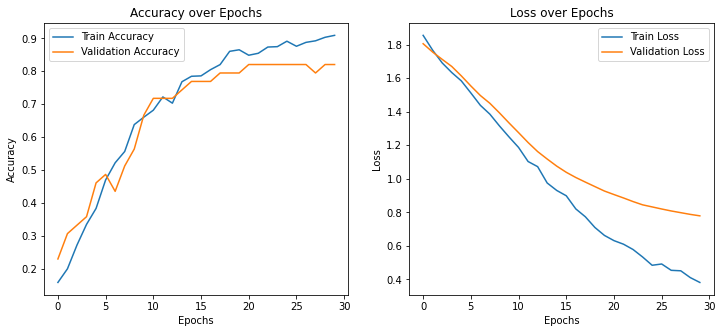

In [6]:
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 경로 설정
base_dir = "./Train_Test_Valid_preprocessed"
train_dir = os.path.join(base_dir, "Train_Cleaned")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

# 🔹 EfficientNetB0 모델 불러오기 (사전 학습된 가중치 사용)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 🔹 새 Fully Connected Layer 추가
x = GlobalAveragePooling2D()(base_model.output)  # GAP 레이어
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # 과적합 방지
x = Dense(6, activation='softmax')(x)  # 예: 해파리 6종 분류

# 🔹 새로운 모델 생성
model = Model(inputs=base_model.input, outputs=x)

# 🔹 EfficientNetB0 일부 레이어만 학습 가능하도록 설정
for layer in base_model.layers[:-50]:  # 마지막 50개 레이어만 학습
    layer.trainable = True
    
# 🔹 모델 컴파일 (학습률 조정)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

# 데이터 증강 및 전처리 (Train 데이터에는 증강 적용, Valid/Test에는 적용 X)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = valid_test_datagen.flow_from_directory(
    valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

# 🔹 모델 학습
history = model.fit(train_generator, validation_data=val_generator, epochs=30, callbacks=[early_stopping])

test_generator = valid_test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

# 모델 평가
loss, acc = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

# 모델 저장
model.save("efficientnetb0_jellyfish.h5")

import matplotlib.pyplot as plt

# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()